# Классификация изображений с эмоциями людей

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tqdm import tqdm

print("TensorFlow Version:", tf.__version__)
print('GPU Device Found.' if tf.config.list_physical_devices('GPU') else 'GPU Device Not Found. Running on CPU')

TensorFlow Version: 2.8.3
GPU Device Not Found. Running on CPU


# <b>Подготовка файлов для работы с локального диска</b>

## Загрузка данных на локальный диск

In [2]:
import gdown
import zipfile
from pathlib import Path

# Загрузка архива
# stable link https://drive.google.com/file/d/1JdDlgpvtlMN99X0eAruGqXrMNi_sh1sg
ident = '1JdDlgpvtlMN99X0eAruGqXrMNi_sh1sg'
fname = 'emotions'

# Пусть к основной папке с изображениями
p = Path('./data')

# Путь к базовой директории, которая будет создана чуть позже
base_dir = p / fname

local_zip = gdown.download(id=ident, output = fname + '.zip')

Downloading...
From: https://drive.google.com/uc?id=1JdDlgpvtlMN99X0eAruGqXrMNi_sh1sg
To: C:\Users\commi\YandexDisk\code_learning\DS_Sber\Профильный_модуль\SBER_Diploma\emotions.zip
100%|█████████████████████████████████████████████████████████████████████████████| 14.8M/14.8M [00:02<00:00, 5.44MB/s]


Распаковка в текущую директорию.

In [3]:
# Пусть к основной папке с изображениями
p = Path('./data')

# Путь к базовой директории, которая будет создана чуть позже
base_dir = p / fname

with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall(p)

Переименуем папку с изображениями в `emotions`.

Для отключения ограничения "Только чтение" у папки с изображениями воспользуемся следующей функцией ([источник](https://www.tutorialspoint.com/How-to-change-the-permission-of-a-directory-using-Python#)):

In [4]:
def change_permissions_recursive(path, mode):
    for root, dirs, files in os.walk(path, topdown=False):
        for dr in [os.path.join(root,d) for d in dirs]:
            os.chmod(dr, mode)
        for file in [os.path.join(root, f) for f in files]:
                os.chmod(file, mode)

In [5]:
import os

zip_content = os.listdir(p)[0]
zip_content

'emotions_dataset'

Функция не всегда срабатывает с первого раза, поэтому запустим следующий цикл:

In [6]:
done = False

while done == False:
    try:
        change_permissions_recursive(p, 0o777)
        change_permissions_recursive(p / zip_content, 0o777)
        zip_content = os.renames(p / zip_content,
                   base_dir)
        done = True
    except:
        continue

Теперь загруженный архив можно удалить.

In [7]:
os.remove(fname + '.zip')

## Настройка и проверка директорий

Проверим содержимое папки с изображениями, мы должны увидеть список из папок с названиями этих папок и их количество. 

In [8]:
from pathlib import Path

# Базовая директория
base_dir = p / fname
# # base_dir = '/content/drive/MyDrive/Sber DS/Diploma/data/emotions/'  # for colab
classes = os.listdir(base_dir)

num_classes = len(classes)

# и ее содержимое
print("Содержимое базовой директории:")
print(classes)
print('Количество классов:', num_classes)

Содержимое базовой директории:
['ANGER', 'DISGUST', 'FEAR', 'JOYFULNESS', 'NEUTRAL']
Количество классов: 5


Переименуем папки в необходимые нам названия классов:

In [9]:
# class_names = [x.lower() for x in classes]
class_names = ['anger', 'disgust', 'fear', 'joyfulness', 'neutral']
    
done = False
while done == False:
    try:
        change_permissions_recursive(base_dir, 0o777)
        done = True
    except:
        continue

done = False
while done == False:
    try:
        for i, class_name in enumerate(class_names):
            change_permissions_recursive(base_dir/class_name, 0o777)
            os.renames(base_dir/classes[i], base_dir/class_name)
        done = True
    except:
        continue

classes = os.listdir(base_dir)

In [10]:
classes

['anger', 'disgust', 'fear', 'joyfulness', 'neutral']

## Удалим некорректные файлы

Если в архиве содержатся некорректные ("битые") файлы, то мы получим ошибку на том или ином этапе обучения и подготовки модели к переносу на мобильное устройство. Код ниже позволяет обнаружить и сразу удалить такие файлы при их наличии. Запустим эту функцию для всех папок с классами ([источник кода](https://github.com/tensorflow/datasets/issues/2188)).

In [11]:
from pathlib import Path
from tensorflow.io import read_file
from tensorflow.image import decode_image

def delete_corrupted_files(folder, base_dir):
    for image in sorted((base_dir / f'{folder}').glob('*')):
        try:
            img = read_file(str(image))
            img = decode_image(img)

            if img.ndim != 3:
                print(f"[FILE_CORRUPT] {str(image).split('/')[-1]} DELETED")
                image.unlink()

        except Exception as e:
            print(f"[ERR] {str(image).split('/')[-1]}: {e} DELETED")
            image.unlink()

In [12]:
for folder in classes:
    print(folder)
    delete_corrupted_files(folder, base_dir)

anger
disgust
[ERR] data\emotions\disgust\5a971597aae6052a008b45a7.webp: Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] DELETED
[ERR] data\emotions\disgust\gettyimages-520925691.webp: Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] DELETED
[ERR] data\emotions\disgust\Universal_Expression_Disgust.webp: Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeImage] DELETED
fear
joyfulness
neutral


Битых файлов нет, можно двигаться дальше.

Сохраним пути к субдиректориям с классами в отдельные переменные и посмотрим на конечное количество изображений в каждом классе.

In [13]:
anger_dir, disgust_dir, fear_dir, joyfulness_dir, neutral_dir = [base_dir / classes[i]
                                                   for i in range(len(classes))]
directories = anger_dir, disgust_dir, fear_dir, joyfulness_dir, neutral_dir


anger_fnames, disgust_fnames, fear_fnames, joyfulness_fnames, neutral_fnames = [os.listdir(i)
                                                              for i in directories]
files_names = anger_fnames, disgust_fnames, fear_fnames, joyfulness_fnames, neutral_fnames


for i, cls_name in enumerate(class_names):
    print(cls_name + ':', len(files_names[i]))

anger: 174
disgust: 292
fear: 177
joyfulness: 339
neutral: 398


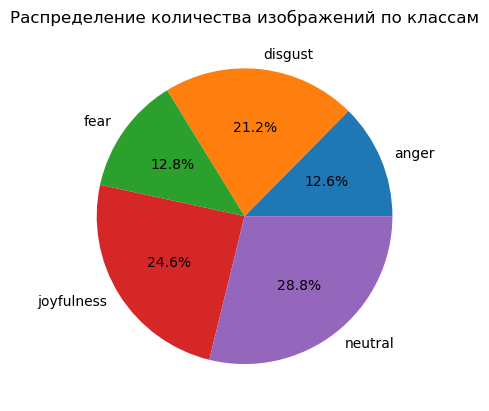

In [14]:
import seaborn as sns

x = np.array([len(anger_fnames), len(disgust_fnames),
              len(fear_fnames), len(joyfulness_fnames),
              len(neutral_fnames)])

plt.title('Распределение количества изображений по классам')
plt.pie(x, labels=classes, autopct='%.1f%%');

Классы несбалансированы, поэтому, помимо метрики `accuracy`, для оценки ошибки классификации мы будем использовать матрицу ошибок. 

Посмотрим на названия отдельных файлов.

In [15]:
len(class_names)

5

In [16]:
for i, j in zip(class_names, files_names):
    print(i, j[90:93])

anger ['278101.jpg', '280.jpg', '28185.jpg']
disgust ['199642.jpg', '200122272-003.jpg', '203679.jpg']
fear ['221981.jpg', '225180.jpg', '227900.jpg']
joyfulness ['16932.jpg', '16936.jpg', '171.jpg']
neutral ['1544.jpg', '15494.jpg', '156106.jpg']


## Визуализация оригинальных изображений

Посмотрим на фотографии из обеих субдиректорий - по 4 фотографии каждого класса.

In [17]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Параметры для отрисовки - количество строк и столбцов
nrows = 5
ncols = 4

# Индекс для итерации изображений
pic_index = 0

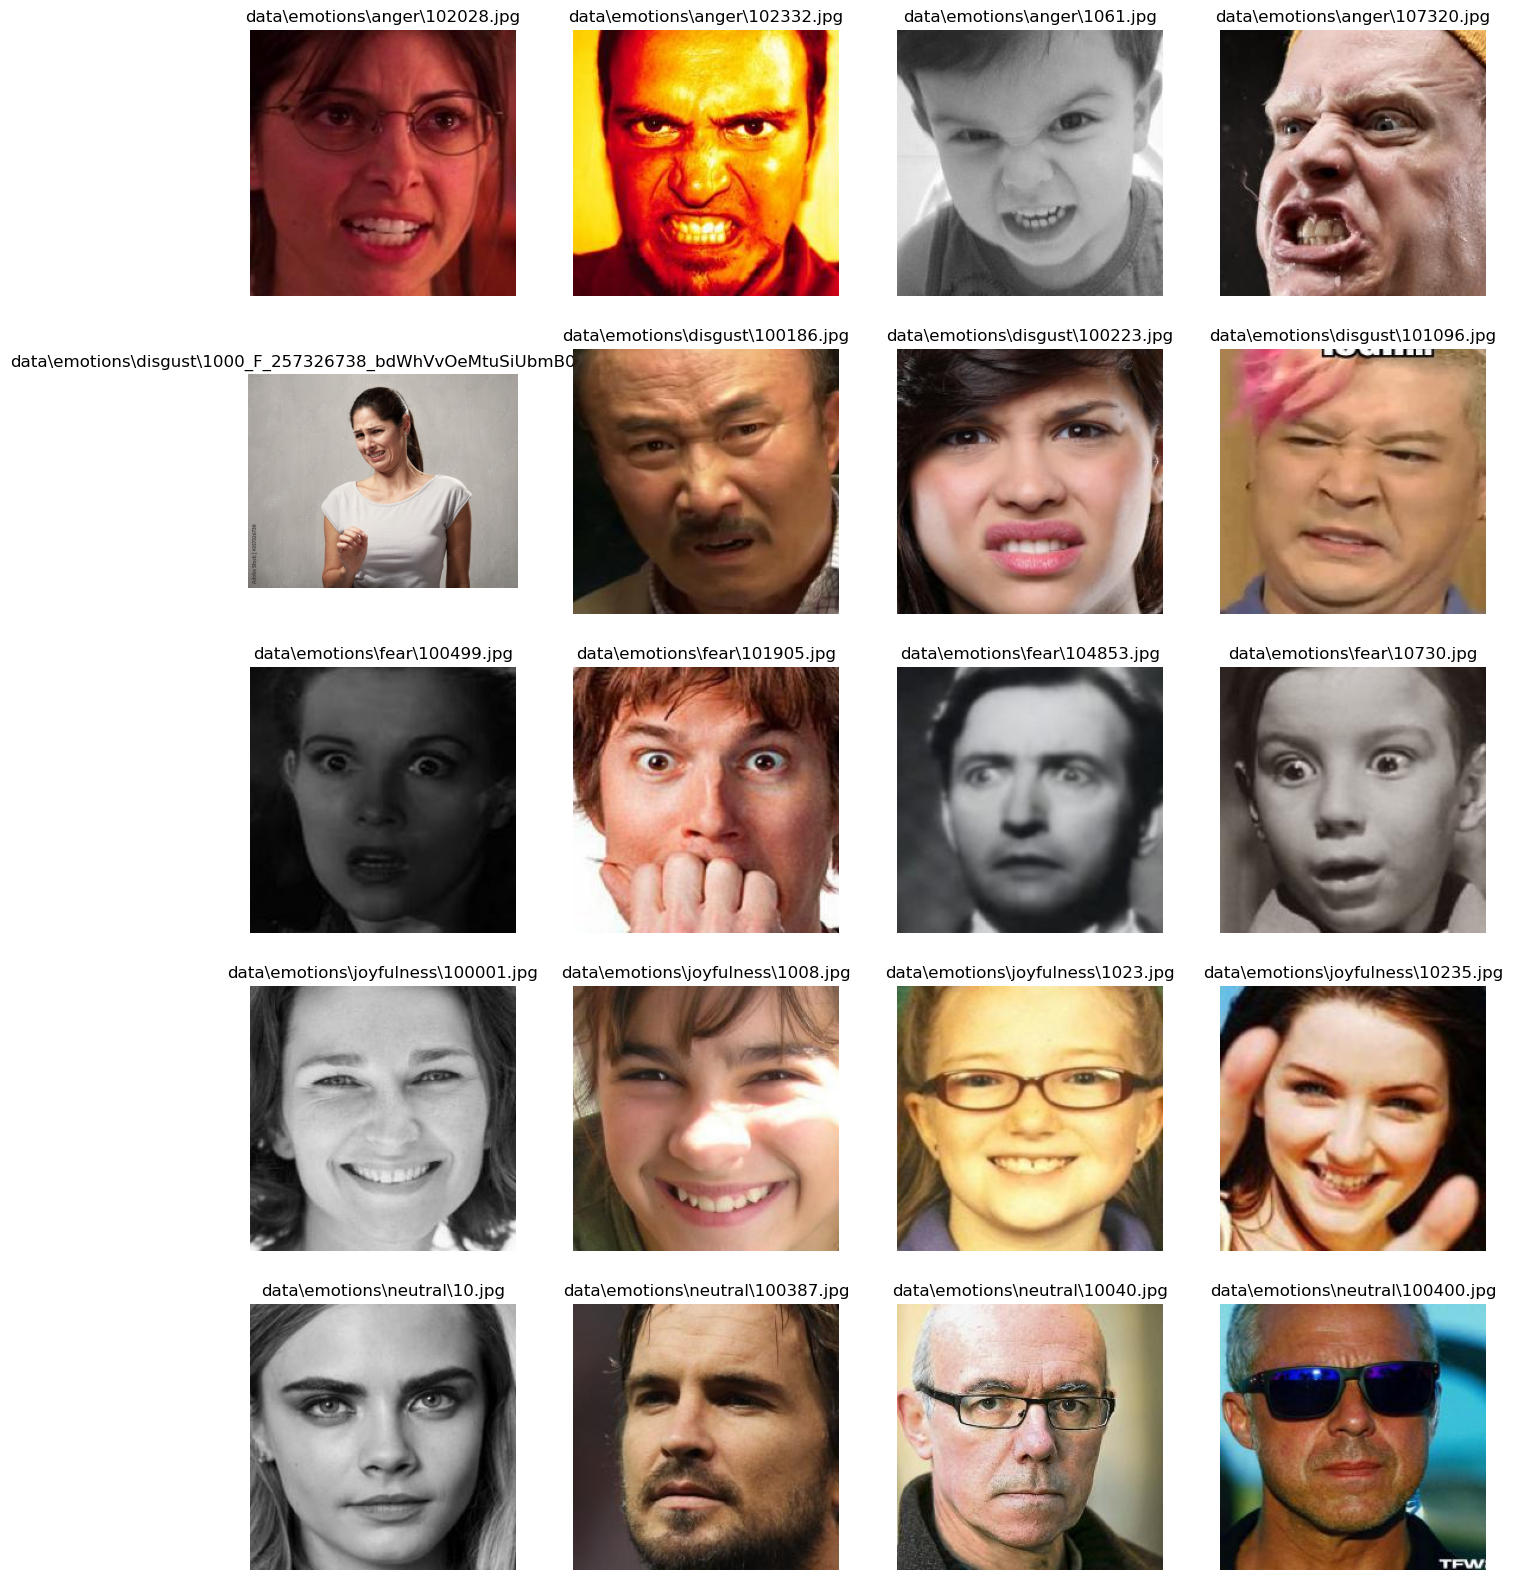

In [18]:
# Запустите эту ячейку несколько раз, чтобы увидеть разные наборы фотографий

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index += 4

next_anger_pic = [os.path.join(anger_dir, fname)
                for fname in anger_fnames[pic_index-4:pic_index]]
next_disgust_pic = [os.path.join(disgust_dir, fname)
                for fname in disgust_fnames[pic_index-4:pic_index]]
next_fear_pic = [os.path.join(fear_dir, fname)
                for fname in fear_fnames[pic_index-4:pic_index]]
next_joyfulness_pic = [os.path.join(joyfulness_dir, fname)
                for fname in joyfulness_fnames[pic_index-4:pic_index]]
next_neutral_pic = [os.path.join(neutral_dir, fname)
                for fname in neutral_fnames[pic_index-4:pic_index]]


for i, img_path in enumerate(next_anger_pic+next_disgust_pic+
                            next_fear_pic+next_joyfulness_pic+
                            next_neutral_pic):
    ax = plt.subplot(nrows, ncols, i+1)
    ax.axis(False)
    plt.title(img_path)
    
    img = mpimg.imread(img_path)
    plt.imshow(img)


Изображения в имеющихся наборах имеют различное разрешение и соотношение сторон, их необходимо привести к единому стандарту на стадии формирования датасетов для нейронной сети. Этим мы сейчас и займемся.

## Split вручную

Так как готовых инструментов для формирования датасета из трех частей (тренировка, валидация, тест) в tensorflow нет, предварительно необходимо разделить все изображения на соответствующие директории, внутри которых будут папки с классами.

Напишем собственную функцию, которая переместит все изображения по нужным нам папкам, создав, таким образом, необходимое разделение данных на три датасета. Функция содержит вложенную функцию `split_numbers`, которая автоматически определит количество изображений, необходимое для каждого сплита по всем классам в соотношении: `train : validation : test = 8:1:1` (значение по умолчанию). Однако при необходимости это соотношение можно изменить в любую сторону, для этого нужно указать значения для тренировочной и валидационной частей, тестовая часть посчитается автоматически как остаток (при этом нужно помнить, что сумма частей, на которые мы делим датасает, должна быть кратна 10; при желании это правило можно изменить, переписав вложенную функцию).

In [19]:
from pathlib import Path
import shutil
import os

def make_split(files_names, base_dir, class_folder, relation=(8, 1)):
    
    dataset_split_folders = 'train', 'validation', 'test'
    train_dir, val_dir, test_dir = [base_dir / i
                    for i in dataset_split_folders]

    for directory in (train_dir, val_dir, test_dir):
        try:
            Path.mkdir(directory)
        except:
            # print(f'Directory {directory} already exists or cannot be created.')
            pass
        try:
            Path.mkdir(directory / class_folder)
        except:
            # print(f'Directory {directory / class_folder} already exists or cannot be created.')
            pass

    def split_numbers(files_names=files_names):
        imgs_num = len(files_names)
        train_num, val_num = int(imgs_num//10*relation[0]), int(imgs_num//10*relation[1])
        test_num = imgs_num - train_num - val_num
        return train_num, val_num, test_num
        
    examples = split_numbers(files_names)
    directories = train_dir, val_dir, test_dir

    for num, dr in zip(examples, directories):
        i = num
        while i != 0:
            image_name = os.listdir(base_dir / class_folder)[i-1]
            shutil.move(base_dir / class_folder / image_name,
                         dr / class_folder / image_name)
            i -= 1

    shutil.rmtree(base_dir / class_folder)

Применим эту функцию к каждому из классов.

In [20]:
for i in range(len(classes)):
    make_split(files_names[i],
             base_dir=base_dir,
             class_folder=classes[i],
             # изменим немного соотношение в пользу валидации
             relation=(8, 1.2))

Наш датасет разделен на три части в соотношении 8:1:1. Теперь у нас имеются три директории, содержащие папки с нужными нам классами.

In [21]:
for i in os.listdir(base_dir):
    print(i, os.listdir(base_dir / i))

test ['anger', 'disgust', 'fear', 'joyfulness', 'neutral']
train ['anger', 'disgust', 'fear', 'joyfulness', 'neutral']
validation ['anger', 'disgust', 'fear', 'joyfulness', 'neutral']


# <b>Создание датасетов под данную предобученную модель</b>

## MobileNet V2

Для нашей задачи в рамках данной части дипломной работы мы будем использовать предобученную модель `MobileNet V2`, которая отличается от первой версии гораздо меньшим количеством параметров при сохранении высоких предсказательных способностей, что критично для имплементации моделей на мобильные устройства. 

Модель разработана в корпорации "Google" и обучена на основе 1,4 млн. изображений для 1000 классов. Это позволяет нам надеяться на то, что мы сможем дообучить нашу модель с небольшим количеством изображений до приемлемого уровня точности, 80%.

В библиотеке TensorFlow существует как минимум два способа использования предобученных моделей:
- использованием библиотеки моделей `tensorflow-hub`,
- с использованием модуля Keras `tf.keras.applications`.

Первый способ проще в имплементации и очень хорошо годится для производства, однако у него есть существенный недостаток для разработчика - предобученные модели поставляются как единый слой и не подлежат частичной разморозке, разморозить можно только все слои зараз, отчего важным становится правильный выбор версии данной модели (`MobileNet V2` в первом случае рассматривается как семейство моделей). Также два способа отличаются методом `rescale` - в первом случае изображения необходимо привести к стандарту [0, 1], тогда как во втором - [-1, 1]. Это необходимо иметь ввиду при подготовке наших изображений перед отправкой на обучение.

Воспользуемся вторым способом, так как он гораздо более пластичен для тонкой настройки и позволяет экспениментировать с гиперпараметрами. 

## Гиперпараметры для модели с переносом обучения

В самом начале обозначим гиперпараметры для будущей модели, это позволит нам уже сейчас начать подготавливать необходимые команды с этими данными для дальнейшего использования. 

`MobileNet V2` позволяет выбрать любое разрешение выше 32х32, мы будем использовать разрешение 224х224. 

In [22]:
MODULE_HANDLE = 'tf.keras.applications.MobileNetV2'
IMAGE_SIZE = (224, 224)
IMG_SHAPE = IMAGE_SIZE + (3,)
BATCH_SIZE = 16

base_learning_rate = 1e-4
dropout = 0.2

print(f"Используем {MODULE_HANDLE}, входное разрешение: {IMAGE_SIZE}, размер батча: {BATCH_SIZE}.")

Используем tf.keras.applications.MobileNetV2, входное разрешение: (224, 224), размер батча: 16.


## Подготовка датасетов

Для обучения модели и затем конвертации ее в облегченную версию все предварительно разделенные по папкам изображения необходимо перевести в формат `dataset`. Для выполнения этой задачи будем использовать метод библиотеки `keras` `image_dataset_from_directory`.

Для корректной работы кода, создающего облегченную версию нашей модели, который мы позаимствовали из курса по компьютерному зрению, тренировочный и валидационный датасеты должны иметь достаточно большой батч, тогда как тестовый датасет должен выдавать по одному изображению зараз, то есть батч должен равняться 1. 

Весь необходимый код оформим в функцию, которая и проделает все операции.

In [23]:
from pathlib import Path

def datasets_prep(base_directory=base_dir,
                  seed=123,
                  batch_size=BATCH_SIZE,
                  image_size=IMAGE_SIZE, 
                  label_mode='categorical'):
    
    train_dir = base_dir / 'train'
    val_dir = base_dir / 'validation'
    test_dir = base_dir / 'test'
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
                            train_dir,
                            label_mode=label_mode,
                            seed=seed,
                            image_size=IMAGE_SIZE,
                            batch_size=batch_size)
    
    val_ds = tf.keras.utils.image_dataset_from_directory(
                            val_dir,
                            label_mode=label_mode,
                            seed=seed,
                            image_size=IMAGE_SIZE,
                            batch_size=batch_size)
    
    test_ds = tf.keras.utils.image_dataset_from_directory(
                            test_dir,
                            label_mode=label_mode,
                            seed=seed,
                            image_size=IMAGE_SIZE,
                            batch_size=1)  # установим батч = 1
    
    return train_ds, val_ds, test_ds

In [24]:
train_batches, validation_batches, test_batches = datasets_prep()

Found 1080 files belonging to 5 classes.
Found 159 files belonging to 5 classes.
Found 141 files belonging to 5 classes.


Проверим созданные датасеты на соответствие заданным выше параметрам.

In [25]:
for ds in (train_batches, validation_batches, test_batches):
    for image_batch, label_batch in ds.take(1):
        print(image_batch.shape)

(16, 224, 224, 3)
(16, 224, 224, 3)
(1, 224, 224, 3)


Как и требовалось, тренировочный и валидационный датасеты содержат в батче установленное количество изображений, тестовый - 1.

Проверим классы, верно ли отработал данный инструмент.

In [26]:
for ds in (train_batches, validation_batches, test_batches):
    print(ds.class_names)
    
class_names = train_batches.class_names
num_classes = len(class_names)

['anger', 'disgust', 'fear', 'joyfulness', 'neutral']
['anger', 'disgust', 'fear', 'joyfulness', 'neutral']
['anger', 'disgust', 'fear', 'joyfulness', 'neutral']


## Визуализация изображений из `train_batches`

C:\Users\commi\AppData\Local\Temp\ipykernel_13320\3032689920.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(4, 4, i+1)


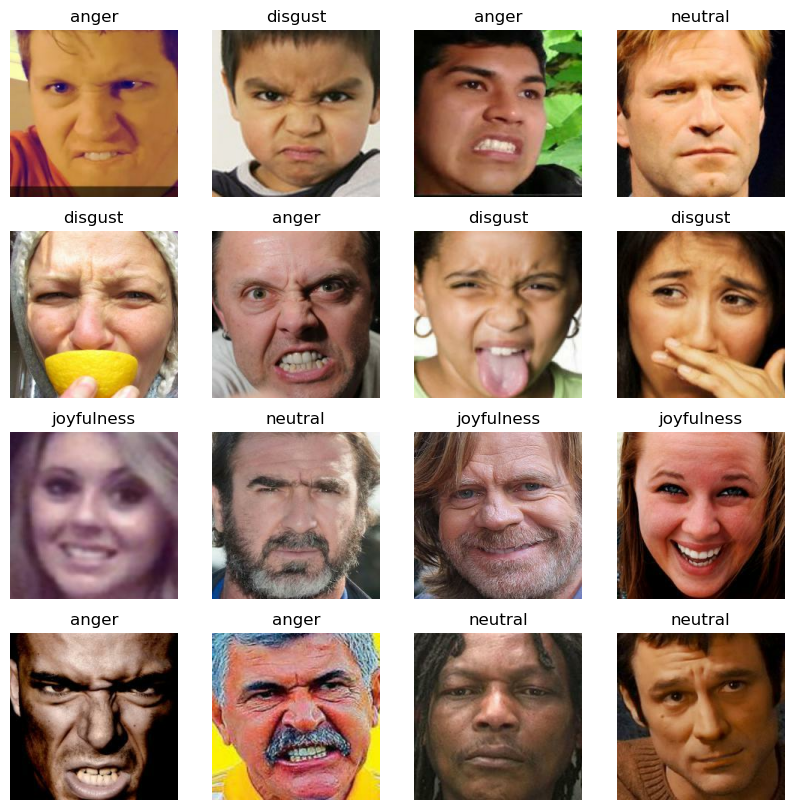

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_batches.take(10):
    for i in range(16):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        category_class = int(tf.argmax(labels[i]))
        plt.title(class_names[category_class])
        plt.axis('off')

Также возьмем одно из изображений из получившегося датасета и посмотрим, получили ли мы желаемое разрешение. Это изображение пригодится нам в дальнейшм, поэтому сохраним его в переменную `one_pic`.

(224, 224, 3)


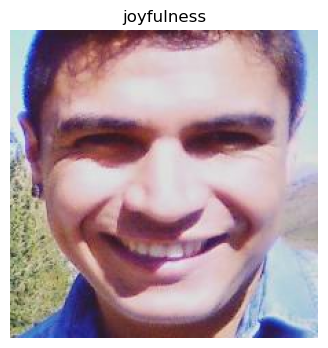

In [28]:
# одно случайное изображение
for images, labels in train_batches.take(10):
    one_pic = images[1].numpy()
    label = labels[1]
    break

print(one_pic.shape)
plt.figure(figsize=(4, 4))
plt.title(class_names[int(tf.argmax(label))])
plt.axis('off')
plt.imshow(one_pic.astype('uint8'));

Итак, датасет для модели создан, все фотографии приведены к единому разрешению, можно переходить к обработке данных для тренировки модели. Обработка данных для нашей модели состоит из двух частей: нормализация значений массива (`rescale`) и агументация данных. Подготовим обе части и запустим две модели - без аугментации и с ней, чтобы посмотреть, как этот блок слоев влияет на работу модели. 

# <b>Подготовка слоев для изображений</b>

## Аугментация данных

Так как наш датасет создан из сравнительно небольшого набора данных, то для избежания переобучения мы воспользуемся всеми доступными возможностями библиотеки `keras`, в частности, добавим в модель слои агументации, которые искусственным образом увеличат количество изображений через внешнее изменение имеющихся. 

Создадим последовательность слоев `RandomFlip` (зеркальное отображение изображения в случайном порядке), `RandomRotation` (поворот изображения по часовой стрелке на случайный угол), `RandomZoom` (увеличение и уменьшение изображения в случайном порядке), а также `RandomContrast`. 

Кроме того, так как это будет наш первый слой, необходимо указать разрешение входных изображений `input_shape`, что мы сделаем через создание дополнительного слоя `InputLayer`.

### Создание последовательности для агументации данных

In [29]:
import tensorflow as tf

data_aug = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE+(3,),),
    tf.keras.layers.RandomFlip('horizontal_and_vertical', name='RandomFlip'),
    tf.keras.layers.RandomRotation(factor=1, fill_mode='reflect',
                                   name='RandomRotation'),
    tf.keras.layers.RandomZoom(height_factor=(-0.3, 0.1), name='RandomZoom'),
    tf.keras.layers.RandomContrast(factor=(0.3, 1), name='RandomContrast')
])

### Визуалиация работы слоя `data_augmentation`

Как и в случае с созданием датасета, проверим на уже использованном изображении из тренировочного датасета, как работает последовательность по аугментации данных. Если следующий блок с кодом запустить несколько раз, то мы увидим, как меняется изображение, проходя через вышеописанные слои.

> _**Note**: В версии tf 2.11.0 при выполнении нижеследующего кода выводятся предупреждения, которые не влияют на качество работы модели._

(1, 224, 224, 3)


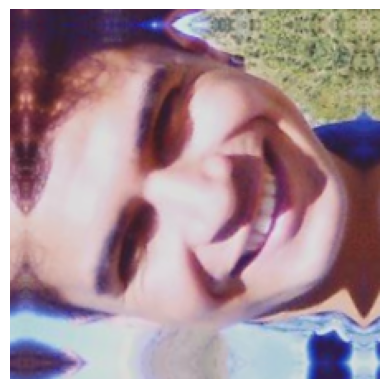

In [30]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# увеличим размерность изображения до 4, так иначе оно не пройдет
# корректно через последовательность слоев
result_for_aug = np.expand_dims(one_pic, axis=0)
augmented = data_aug(result_for_aug)
print(augmented.shape)

plt.axis('off')

# вернем результату размерность 3 для отображения
plt.imshow(np.squeeze(augmented).astype('uint8'));

Видим, что некоторые каналы из-за усиления контрастности дают выжженные пиксели. Эта особенность будет выправлена следующей операцией - `rescale`, которая при приведении значений к стандарту [-1, 1] также влияет на контраст. В итоге мы получим более менее нормализованную картинку. При желании слой с контрастом, как и другие слои аугментации, всегда можно отключить или изменить параметры, но нас устраивает такой результат.

## Rescale

Так как мы используем предобученную модель модуля `Keras`, нам необходимо отшкалировать значения матриц изображений по стандарту от -1 до 1. Данный слой можно создать двумя путями:

In [56]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1, name='Rescaling')

Проверим качество работы слоя на фотографии, которую мы использовали выше.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 1, 224, 224, 3)
(224, 224, 3)
Минимальное и максимальное значение пикселей: -0.8324994 0.9787606


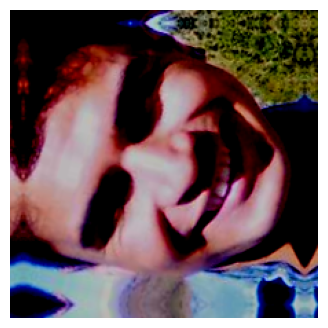

In [33]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

# увеличим размерность изображения до 4, так иначе оно не пройдет
# корректно через слой
result_for_rescale = rescale(np.expand_dims(augmented, axis=0))
print(result_for_rescale.shape)

# вернем результату размерность 3 для отображения
result = np.squeeze(result_for_rescale)
print(result.shape)

plt.figure(figsize=(4, 4))
plt.axis('off')
plt.imshow(result)

# print("Picture's shape:", result.shape)
print("Минимальное и максимальное значение пикселей:", result.min(), result.max())

Слой отработал ожидаемым образом, при этом видно, что изменился контраст изображения, как мы и ожидали.

Необходимо заметить, что при использовании метода шкалирования от 0 до 1 контраст изображения не изменяется, при этом слой по изменению контраста отрабатывает гораздо слабее. В этом случае слои аугментации можно ставить после слоя `rescale`.

Итак, обе последовательности вполне успешно справляются с поставленными перед ними задачами. Переходим к созданию и обучению моделей.

## Оптимизация работы кэша

Оптимизируем работу кэша следующим кодом:

In [34]:
train_batches = train_batches.cache().prefetch(buffer_size=1)
validation_batches = validation_batches.cache().prefetch(buffer_size=1)

# <b>Модель 1</b> | Baseline

## Модуль `tf.keras.applications` | `feature_extractor_layer`

Создадим `feature_extractor`, который извлечет веса из предобученной модели `tensorflow` для переноса обучения на нашу модель. При переносе обучения в первую очередь обычно отключают "верхние", то есть последние слои предобученной модели: именно в них происходит обучение на данную классификацию. Выбрав опцию `include_top=False` мы оставляем для нашей модели все слои до самого последнего перед слоем `Flatten` предобученной модели (в литературе его называют слоем "бутылочным горлышком" - "bottleneck layer"), куда мы поместим наши собственные слои. Признаки, содержащиеся в "бутылочном горлышке", представляют важнейшую ценность, так как именно они обладают наибольшей общностью признаков изображений в отличие от более специфичных в верхних слоях.

В дальнейшем мы также будем использовать отдельные слои предобученной модели, количество которых мы будем определять опытным путем. За "разморозку" слоев у нас будет отвечать параметр `do_fine_tuning`, который может принимать только булевы значения. 

Для базовой модели мы не будем отключать последние слои предобученной модели и размораживать более глубокие слои. Воспользуемся предобученной моделью "как есть".

In [68]:
do_fine_tuning = False
feature_extractor = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')
feature_extractor.trainable = do_fine_tuning

print(f'Разморозка слоев: {do_fine_tuning}.')

Разморозка слоев: False.


## Архитектура модели

In [69]:
print(f'Строим модель на базе {MODULE_HANDLE}.')
print(f'Разморозка слоев: {do_fine_tuning}.\n')

model = tf.keras.Sequential([
            rescale,
            feature_extractor,
            # tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.Dense(num_classes, activation='softmax')
], name='baseline')

model.build(input_shape=(None,) + IMAGE_SIZE + (3,))
model.summary()

Строим модель на базе tf.keras.applications.MobileNetV2.
Разморозка слоев: False.

Model: "baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1000)             3538984   
 ional)                                                          
                                                                 
 dropout_9 (Dropout)         (None, 1000)              0         
                                                                 
 dense_9 (Dense)             (None, 5)                 5005      
                                                                 
Total params: 3,543,989
Trainable params: 5,005
Non-trainable params: 3,538,984
_________________________________________________________________


In [72]:
len(model.trainable_variables)

2

## Компиляция

In [73]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

## Обучение модели

In [74]:
EPOCHS = 10

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Epoch 1/2
68/68 [==============================] - 78s 1s/step - loss: 1.6090 - accuracy: 0.2472 - val_loss: 1.6074 - val_accuracy: 0.2830
Epoch 2/2
68/68 [==============================] - 70s 1s/step - loss: 1.6069 - accuracy: 0.2787 - val_loss: 1.6056 - val_accuracy: 0.2830


## Визуализация данных по работе алгоритма

Посмотрим на то, как вели себя функция потерь и `accuracy` на тренировочном и валидационном датасетах на всех итерациях нашей модели. Напишем функцию, которая нам пригодится и в дальнейшем.

In [39]:
def val_acc_viz(history, epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(1, EPOCHS+1)

    sns.set_style('whitegrid')
    plt.figure(figsize=(8, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='best')
    plt.title('Accuracy')
    plt.xlabel('epochs')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='best')
    plt.title('Loss')
    plt.xlabel('epochs')
    plt.show()

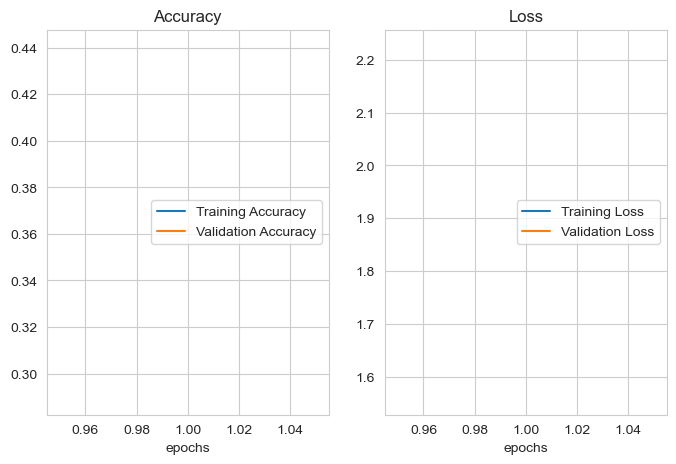

In [40]:
val_acc_viz(hist, EPOCHS)

## Предсказание модели

### На изображениях из Сети

При желании качество работы модели можно проверить на реальных фотографиях экспертным методом. Для этого создадим новую папку, куда загрузим желаемые изображения. Далее, подготовленная функция преобразует изображения в необходимый для визуализации и предсказания формат. Оставим эту часть в качестве дополнения, использовать ее пока не будем.

In [41]:
# from PIL import Image
# import numpy as np
# from tensorflow.keras.utils import load_img, img_to_array
# import os

# new_test_dir = Path('./data/test_images')
# Path.mkdir(new_test_dir)

# def show_predictions(model):
    
#     images = os.listdir(new_test_dir)
    
#     for i, img_path in enumerate(images):

#         # путь к тестовым изображениям
#         path = new_test_dir / img_path

#         # приведение изображений к желаемому разрешению
#         img = load_img(path, target_size=IMAGE_SIZE + (3,))
#         # перевод изображения в массив
#         x = img_to_array(img)

#         # добавление четвертого измерения для модели
#         images = np.expand_dims(x, axis=0)
        
#         plt.figure(figsize=(2, 2))
#         # Отключить оси
#         plt.axis(False)
#         plt.imshow(np.squeeze(images).astype('uint8'))
#         # plt.title(img_path)
#         plt.show()

#         # предсказание
#         classes = model.predict(images, batch_size=10)

#         class_pred = np.argmax(classes)
#         # print(np.argmax(class_pred))
#         print(f'{img_path} is {class_names[class_pred]} ({np.max(classes[0])*100:.2f}%)')
        
# show_predictions(model)

### На изображениях из тестовой выборки

Посмотрим на то, как модель предсказывает тестовые изображения, хранящиеся в третьей, тестовой выборке, которая до этого момента не принимала участия в работе. Напомним, что тестовая выбора разбита на батчи по одному изображению, что позволяет нам проще контролировать количество изображений, которое мы хотим использовать для предсказания. Следующая функция покажет изображение, заданное и предсказанное значение класса, а также "уверенность" модели в своем предсказании. На данном этапе посмотрим на небольшое количество изображений (по умолчанию 10, можно изменить это число, задав соответствующий аргумент), а полную картину оценим дальше, построив матрицу ошибок.

In [42]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
import os

def show_predictions(model, image_set=test_batches,
                     images_number=10, visualization=False):

    images = image_set.take(images_number)

    for img, label in images:

        if visualization == True:
            plt.figure(figsize=(2, 2))
            # Отключить оси
            plt.axis(False)
            # оставим три измерения из четырех
            image = np.squeeze(img)
            plt.imshow(image.astype('uint8'))
            plt.show()

        # реальный класс
        label = np.argmax(label)
        # предсказанный класс
        prediction = model.predict(img)
        pred = np.argmax(prediction)

        print(f'{class_names[label]} is {class_names[pred]} ({np.max(prediction[0])*100:.2f}%)')

In [43]:
show_predictions(model)

joyfulness is fear (36.51%)
neutral is joyfulness (33.70%)
anger is joyfulness (47.72%)
neutral is joyfulness (69.43%)
neutral is fear (32.84%)
fear is disgust (80.32%)
neutral is disgust (45.00%)
anger is fear (44.56%)
neutral is neutral (66.14%)
disgust is joyfulness (39.62%)


## Матрица ошибок

Напишем функцию для отображения матрицы ошибок, которая пригодится нам и в дальнейшем.

In [ ]:
def confusion_matrix(model, images_number=None, dataset=test_batches, class_names=class_names):

    '''
    Выводит матрицу ошибок на тестовых данных. 
    
    Аргументы:
    - model - обученная модель.
    - images_number - количество изображений из тестовой выборки;
            если None, то используются все изображения в выборке.
    - dataset - tf.dataset с тестовыми изображениями.
    '''
    
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    if images_number is None:
        test_images = dataset
    else:
        test_images = dataset.take(images_number)
        
    y_test, y_pred = ([np.argmax(y) for _, y in test_images], 
                      [np.argmax(x) for x in model.predict(test_images)])
        
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot()
    plt.show()

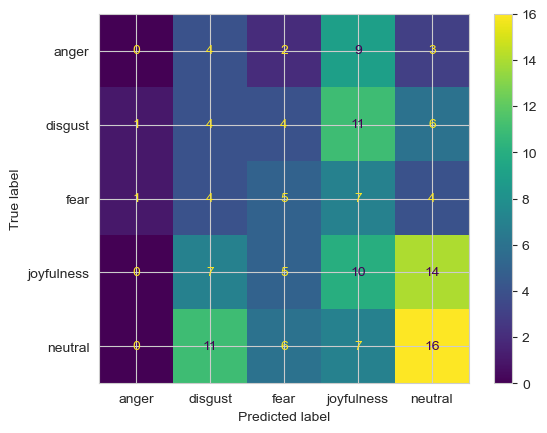

In [44]:
confusion_matrix(model)

## Вывод

Модель начала переобучаться практически с первых эпох, при этом максимальная точность на валидационном датасете находится в районе 50%:

In [45]:
val_acc_best = np.max(hist.history['val_accuracy'])
baseline_best_result = round(val_acc_best, 2)
baseline_best_result

0.44

In [46]:
# сохраним данные о модели
model_1 = model
hist_1 = hist

# <b>Модель 2</b> | Bottleneck layer

## Модуль `tf.keras.applications` | `feature_extractor_layer`

Теперь попробуем отключить самые верхние слои на классификацию и обучить собственный классификатор. Остальные гиперпараметры не трогаем.

In [47]:
do_fine_tuning = False
feature_extractor = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
feature_extractor.trainable = do_fine_tuning

## Архитектура модели

In [48]:
print(f'Строим модель на базе {MODULE_HANDLE}.')
print(f'Разморозка слоев: {do_fine_tuning}.\n')

model = tf.keras.Sequential([

            data_aug,
            rescale,

            feature_extractor,

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.Dense(num_classes, activation='softmax')

], name='data_augmentation_model')

model.build(input_shape=(None,) + IMAGE_SIZE + (3,))
model.summary()

Строим модель на базе tf.keras.applications.MobileNetV2.
Разморозка слоев: False.

Model: "data_augmentation_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 Rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dropout_1 (Dropout)         (None, 62720)             0         
                                                                 
 dense_1 (Dense)          

## Компиляция

In [49]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

## Обучение модели

In [50]:
EPOCHS = 20

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Epoch 1/10
68/68 [==============================] - 80s 1s/step - loss: 2.3106 - accuracy: 0.3315 - val_loss: 2.0641 - val_accuracy: 0.3836
Epoch 2/10
68/68 [==============================] - 89s 1s/step - loss: 1.7395 - accuracy: 0.4815 - val_loss: 1.6680 - val_accuracy: 0.3962
Epoch 3/10
68/68 [==============================] - 89s 1s/step - loss: 1.6261 - accuracy: 0.4963 - val_loss: 1.6985 - val_accuracy: 0.3585
Epoch 4/10
68/68 [==============================] - 79s 1s/step - loss: 1.4400 - accuracy: 0.5546 - val_loss: 1.7026 - val_accuracy: 0.4780
Epoch 5/10
68/68 [==============================] - 81s 1s/step - loss: 1.3624 - accuracy: 0.5731 - val_loss: 1.7141 - val_accuracy: 0.4591
Epoch 6/10
68/68 [==============================] - 81s 1s/step - loss: 1.2392 - accuracy: 0.5870 - val_loss: 1.5658 - val_accuracy: 0.4780
Epoch 7/10
68/68 [==============================] - 79s 1s/step - loss: 1.2994 - accuracy: 0.6046 - val_loss: 1.4348 - val_accuracy: 0.5094
Epoch 8/10
68/68 [==

## Визуализация данных по работе алгоритма

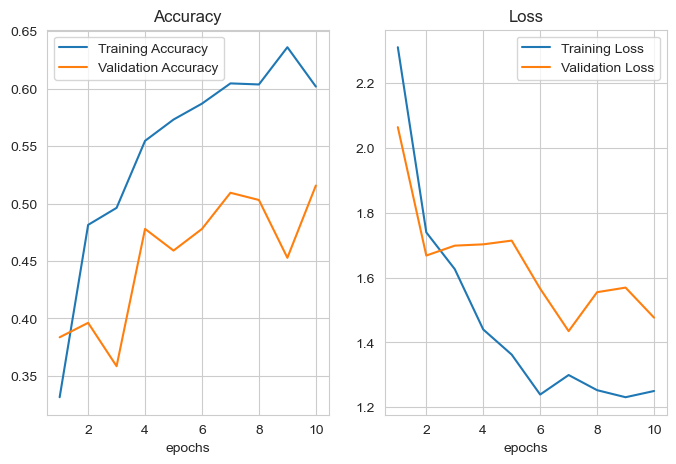

In [51]:
val_acc_viz(hist, EPOCHS)

## Предсказание модели

In [52]:
show_predictions(model)

neutral is neutral (97.25%)
joyfulness is joyfulness (54.57%)
neutral is neutral (96.21%)
neutral is neutral (99.75%)
disgust is disgust (74.66%)
fear is fear (50.41%)
anger is anger (41.76%)
neutral is neutral (77.14%)
neutral is neutral (65.68%)
disgust is neutral (88.45%)


## Матрица ошибок

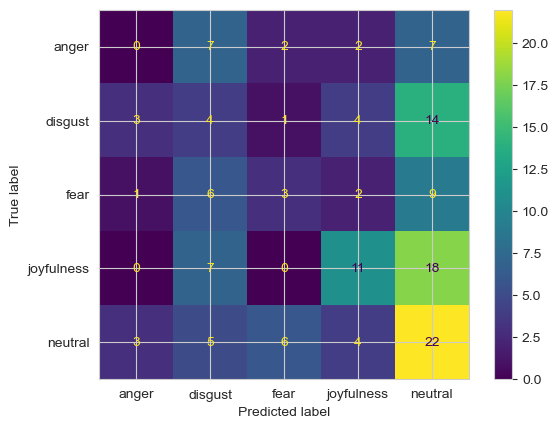

In [53]:
confusion_matrix(model)

## Вывод

Модель по-прежнему сильно ошибается, однако использование слоя аугментации

In [54]:
val_acc_best = np.max(hist.history['val_accuracy'])
model_2_best_result = round(val_acc_best, 2)
model_2_best_result

0.52

In [55]:
# сохраним данные о модели
model_2 = model
hist_2 = hist

# <b>Модель 3</b> | Data augmentation

## Модуль `tf.keras.applications` | `feature_extractor_layer`

На данном этапе для преодоления проблемы переобучения добавим в модель слои с аугментацией данных, которые мы подготовили заранее. Другие параметры оставим нетронутыми.

In [47]:
do_fine_tuning = False
feature_extractor = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
feature_extractor.trainable = do_fine_tuning

## Архитектура модели

In [48]:
print(f'Строим модель на базе {MODULE_HANDLE}.')
print(f'Разморозка слоев: {do_fine_tuning}.\n')

model = tf.keras.Sequential([

            data_aug,
            rescale,

            feature_extractor,

            tf.keras.layers.Flatten(),
            tf.keras.layers.Dropout(dropout),
            tf.keras.layers.Dense(num_classes, activation='softmax')

], name='data_augmentation_model')

model.build(input_shape=(None,) + IMAGE_SIZE + (3,))
model.summary()

Строим модель на базе tf.keras.applications.MobileNetV2.
Разморозка слоев: False.

Model: "data_augmentation_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 Rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                                 
 dropout_1 (Dropout)         (None, 62720)             0         
                                                                 
 dense_1 (Dense)          

## Компиляция

In [49]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

## Обучение модели

In [50]:
EPOCHS = 20

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Epoch 1/10
68/68 [==============================] - 80s 1s/step - loss: 2.3106 - accuracy: 0.3315 - val_loss: 2.0641 - val_accuracy: 0.3836
Epoch 2/10
68/68 [==============================] - 89s 1s/step - loss: 1.7395 - accuracy: 0.4815 - val_loss: 1.6680 - val_accuracy: 0.3962
Epoch 3/10
68/68 [==============================] - 89s 1s/step - loss: 1.6261 - accuracy: 0.4963 - val_loss: 1.6985 - val_accuracy: 0.3585
Epoch 4/10
68/68 [==============================] - 79s 1s/step - loss: 1.4400 - accuracy: 0.5546 - val_loss: 1.7026 - val_accuracy: 0.4780
Epoch 5/10
68/68 [==============================] - 81s 1s/step - loss: 1.3624 - accuracy: 0.5731 - val_loss: 1.7141 - val_accuracy: 0.4591
Epoch 6/10
68/68 [==============================] - 81s 1s/step - loss: 1.2392 - accuracy: 0.5870 - val_loss: 1.5658 - val_accuracy: 0.4780
Epoch 7/10
68/68 [==============================] - 79s 1s/step - loss: 1.2994 - accuracy: 0.6046 - val_loss: 1.4348 - val_accuracy: 0.5094
Epoch 8/10
68/68 [==

## Визуализация данных по работе алгоритма

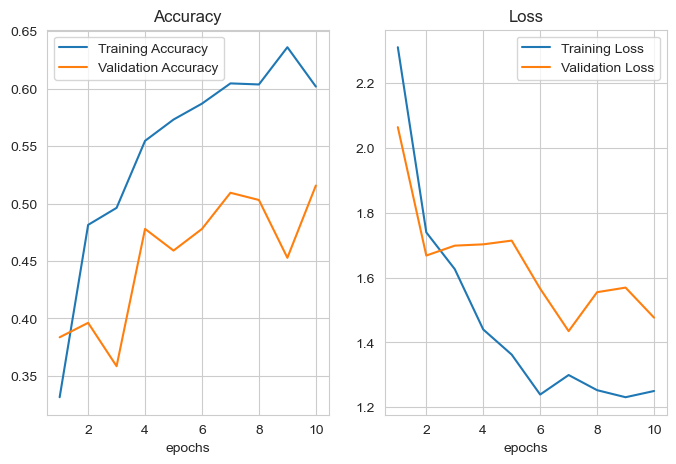

In [51]:
val_acc_viz(hist, EPOCHS)

## Предсказание модели

In [52]:
show_predictions(model)

neutral is neutral (97.25%)
joyfulness is joyfulness (54.57%)
neutral is neutral (96.21%)
neutral is neutral (99.75%)
disgust is disgust (74.66%)
fear is fear (50.41%)
anger is anger (41.76%)
neutral is neutral (77.14%)
neutral is neutral (65.68%)
disgust is neutral (88.45%)


## Матрица ошибок

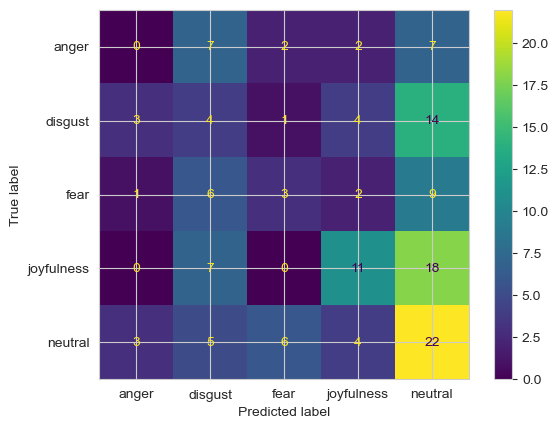

In [53]:
confusion_matrix(model)

Выводы: модель по-прежнему сильно ошибается, однако использование слоя аугментации

In [54]:
val_acc_best = np.max(hist.history['val_accuracy'])
model_2_best_result = round(val_acc_best, 2)
model_2_best_result

0.52

In [55]:
# сохраним данные о модели
model_3 = model
hist_3 = hist

# <b>Модель 4</b> | Больше слоёв классификатора

# <b>Модель 5</b> | `fine_tuning`

## Модуль `tf.keras.applications` | `feature_extractor_layer`

На следующем шаге проверим эту же модель, но разморозим часть слоев предобученной модели. В официальных документах указано, что размораживать слои следует только после того, как мы уже обучили собственный классификатор, в ином случае предобученная модель с установленными в случайном порядке весами для новых слоев при обновлении весов потеряет все, чему она была обучена.

Кроме того, нет необходимости в разморозке "нижних слоев", так как они обнаруживают самые простые и общие закономерности, характерные для любых изображений. Цель применения предобученной модели - использовать более "специализированные" слои для дообучения новой модели на новом датасете, поэтому возьмем сравнительно небольшое число "верхних" слоев.

Особого внимания в случае разморозки `feature_extractor` заслуживают слои bacth normalization (`BN`). Это единственные встроенные слои, веса которых не должны обновляться при градиентном спуске, так как эти веса - движущиеся среднее значение и стандартное отклонение для нормализации текущего батча. Запустив модель в режиме `trainable=False`, мы эти слои заморозили. Когда мы на следующем шаге размораживаем всю модель или ее часть, слои BN продолжают работать в режиме inference (движущиеся mean и std), а не обучения (mean и std текущего батча). Это очень важный момент, так как если мы запустим `feature_extractor` сразу в режиме разморозки без предварительного обучения на замороженных слоях (то есть не заморозим веса BN), слои BN будут давать непредсказуемый результат (подробнее о проблеме [здесь](https://keras.io/getting_started/faq/#whats-the-difference-between-the-training-argument-in-call-and-the-trainable-attribute)).

In [100]:
do_fine_tuning = True
feature_extractor = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
feature_extractor.trainable = do_fine_tuning

print(f'Разморозка слоев: {do_fine_tuning}.')

Разморозка слоев: True.


Посмотрим на количество слоев в предобученной модели:

In [112]:
print("Number of layers in the feature extractor: ", len(feature_extractor.layers))
print("Trainable layers in the feature extractor: ", len(feature_extractor.trainable_variables))

Number of layers in the feature extractor:  154
Trainable layers in the feature extractor:  54


In [108]:
# с какого слоя мы размораживаем модель
fine_tune_at = 100

# Заморозим все остальные слои
for layer in feature_extractor.layers[:fine_tune_at]:
    layer.trainable = False

## Компиляция

Теперь необходимо скомпилировать нашу уже обученную на предыдущем этапе модель, чтобы изменения были применены.

In [109]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

## Архитектура модели

In [110]:
model.summary()

Model: "baseline"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_2 (Flatten)         (None, 62720)             0         
                                                                 
 dropout_3 (Dropout)         (None, 62720)             0         
                                                                 
 dense_3 (Dense)             (None, 5)                 313605    
                                                                 
Total params: 2,571,589
Trainable params: 313,605
Non-trainable params: 2,257,984
_________________________________________________________________


In [120]:
len(model.trainable_variables)

2

Итак, у нашей модели 2 переменные, которые будут обучаться - это переменные с весами и свободными членами.

## Обучение модели

In [ ]:
EPOCHS = 15

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches,
                 )

# <b>Модель 6</b> | Финальная модель

Финальная модель будет состоять из двух частей:
- обучение классификатора на предобученой модели с замороженными слоями,
- дообучение классификатора на размороженных слоях.

## Callback

В этом блоке мы применим такой метод, как `callback`, который прекратит обучение и восстановит лучшие параметры, когда модель начнет переобучаться. Использованием данного инструмента позволяет нам установить сравнительно большое количество эпох без страха впустую потратить ресурсы, так как модель сама прекратит обучение, достигнув лучшего результата.

In [ ]:
from tensorflow.keras import layers, callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001,  # minimium amount of change to count as an improvement
    patience=20,  # how many epochs to wait before stopping
    restore_best_weights=True,
)